 Code based on  :https://www.kaggle.com/todnewman/keras-neural-net-for-champs
>  and https://www.kaggle.com/criskiev/distance-is-all-you-need-lb-1-481

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import gc
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from keras.layers import Dense, Input, Activation
from keras.layers import BatchNormalization,Add,Dropout
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K



Using TensorFlow backend.


In [2]:
print(os.listdir("../input"))

['dipole_moments.csv', 'magnetic_shielding_tensors.csv', 'mulliken_charges.csv', 'potential_energy.csv', 'sample_submission.csv', 'scalar_coupling_contributions.csv', 'structures', 'structures.csv', 'test.csv', 'train.csv']


In [3]:
DATA_PATH = '../input/'
SUBMISSIONS_PATH = './'
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [4]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv(f'{DATA_PATH}/train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
train_csv.head(10)

,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404
5,1,2,3,2JHH,-11.254100
6,1,2,4,2JHH,-11.254800
7,1,3,0,1JHC,84.809303
8,1,3,4,2JHH,-11.254300


In [5]:
submit = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')

In [6]:
test_csv = pd.read_csv(f'{DATA_PATH}/test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
test_csv.head(10)

,molecule_index,atom_index_0,atom_index_1,type
id,,,,
4658147,4,2,0,2JHC
4658148,4,2,1,1JHC
4658149,4,2,3,3JHH
4658150,4,3,0,1JHC
4658151,4,3,1,2JHC
4658152,15,3,0,1JHC
4658153,15,3,2,3JHC
4658154,15,3,4,2JHH
4658155,15,3,5,2JHH


In [7]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv(f'{DATA_PATH}/structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_csv.head(10)

,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397
5,2,0,7,-0.040426,1.024108,0.062564
6,2,1,1,0.017257,0.012545,-0.027377
7,2,2,1,0.915789,1.358745,-0.028758
8,2,3,1,-0.520278,1.343532,-0.775543
9,3,0,8,-0.034360,0.977540,0.007602


In [8]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures

In [9]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [10]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [11]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [12]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [13]:

def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [14]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [15]:
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=15):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack() 
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    full.sort_values('id', inplace=True)
    
    return full

In [16]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    return df[labels]

In [21]:
def create_nn_model(input_shape):
    inp = Input(shape=(input_shape,))
    #x = Dense(2048, activation="relu")(inp)
    x = Dense(100, activation="relu")(inp)
    x = BatchNormalization()(x)
    #x = Dense(1024, activation="relu")(x)
    #x = BatchNormalization()(x)
    #x = Dense(1024, activation="relu")(x)
    #x = BatchNormalization()(x)
    #x = Dense(512, activation="relu")(x)
    #x = BatchNormalization()(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    out = Dense(1, activation="linear")(x)  
   # out1 = Dense(2, activation="linear")(x)#mulliken charge 2
   # out2 = Dense(6, activation="linear")(x)#tensor 6(xx,yy,zz)
   # out3 = Dense(12, activation="linear")(x)#tensor 12(others) 
   # out4 = Dense(1, activation="linear")(x)#scalar_coupling_constant 
    #model = Model(inputs=inp, outputs=[out,out1,out2,out3,out4])
    model = Model(inputs=inp, outputs=[out])
    return model

In [22]:
def plot_history(history, label):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss for %s' % label)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

In [23]:
# Set up GPU preferences
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = tf.Session(config=config) 
K.set_session(sess)

Training 1JHC out of [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN]
Categories (8, object): [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN] 

Train on 638474 samples, validate on 70942 samples
Epoch 1/3
638474/638474 [==============================] - 7s 11us/step - loss: 56.7800 - val_loss: 5.4752
Epoch 2/3
638474/638474 [==============================] - 6s 10us/step - loss: 2.0892 - val_loss: 1.9069
Epoch 3/3
638474/638474 [==============================] - 6s 10us/step - loss: 1.8333 - val_loss: 1.7706


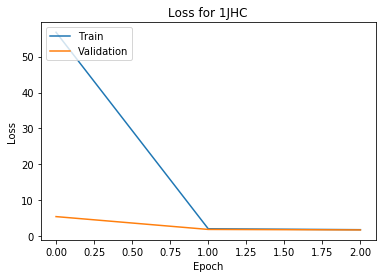

0.5713274
Training 2JHH out of [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN]
Categories (8, object): [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN] 

Train on 340232 samples, validate on 37804 samples
Epoch 1/3
340232/340232 [==============================] - 4s 11us/step - loss: 4.4586 - val_loss: 1.2024
Epoch 2/3
340232/340232 [==============================] - 3s 10us/step - loss: 0.6235 - val_loss: 0.6523
Epoch 3/3
340232/340232 [==============================] - 3s 10us/step - loss: 0.5394 - val_loss: 0.5170


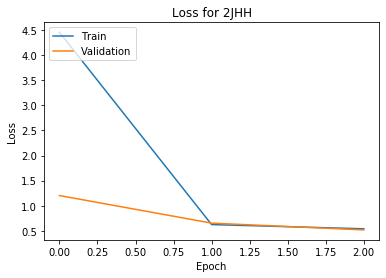

-0.65978986
Training 1JHN out of [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN]
Categories (8, object): [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN] 

Train on 39026 samples, validate on 4337 samples
Epoch 1/3
39026/39026 [==============================] - 1s 19us/step - loss: 47.2035 - val_loss: 46.7031
Epoch 2/3
39026/39026 [==============================] - 0s 10us/step - loss: 46.1861 - val_loss: 45.3243
Epoch 3/3
39026/39026 [==============================] - 0s 10us/step - loss: 44.4262 - val_loss: 43.0122


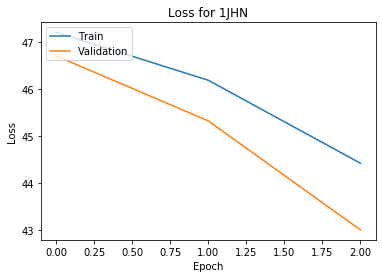

3.7614846
Training 2JHN out of [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN]
Categories (8, object): [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN] 

Train on 107327 samples, validate on 11926 samples
Epoch 1/3
107327/107327 [==============================] - 1s 13us/step - loss: 2.2823 - val_loss: 1.0635
Epoch 2/3
107327/107327 [==============================] - 1s 10us/step - loss: 0.7291 - val_loss: 0.6763
Epoch 3/3
107327/107327 [==============================] - 1s 10us/step - loss: 0.5548 - val_loss: 0.5297


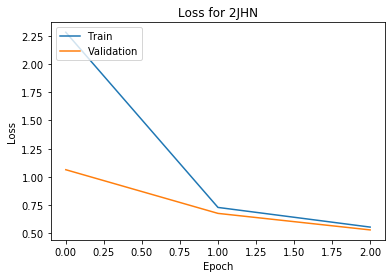

-0.63539445
Training 2JHC out of [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN]
Categories (8, object): [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN] 

Train on 1026606 samples, validate on 114068 samples
Epoch 1/3
1026606/1026606 [==============================] - 10s 10us/step - loss: 1.1598 - val_loss: 0.9286
Epoch 2/3
1026606/1026606 [==============================] - 10s 10us/step - loss: 0.8210 - val_loss: 0.7633
Epoch 3/3
1026606/1026606 [==============================] - 10s 10us/step - loss: 0.7367 - val_loss: 0.7374


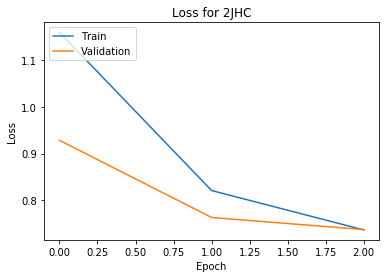

-0.3045957
Training 3JHH out of [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN]
Categories (8, object): [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN] 

Train on 531549 samples, validate on 59062 samples
Epoch 1/3
531549/531549 [==============================] - 5s 10us/step - loss: 1.4907 - val_loss: 0.7103
Epoch 2/3
531549/531549 [==============================] - 5s 9us/step - loss: 0.6133 - val_loss: 0.5785
Epoch 3/3
531549/531549 [==============================] - 5s 10us/step - loss: 0.5423 - val_loss: 0.5168


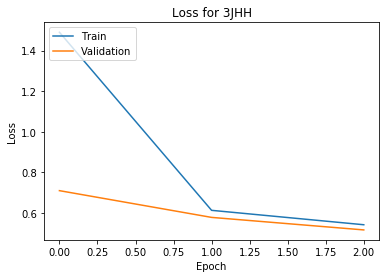

-0.6600071
Training 3JHC out of [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN]
Categories (8, object): [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN] 

Train on 1359341 samples, validate on 151038 samples
Epoch 1/3
1359341/1359341 [==============================] - 14s 10us/step - loss: 1.1568 - val_loss: 0.8379
Epoch 2/3
1359341/1359341 [==============================] - 13s 10us/step - loss: 0.8005 - val_loss: 0.7596
Epoch 3/3
1359341/1359341 [==============================] - 13s 10us/step - loss: 0.7411 - val_loss: 0.7086


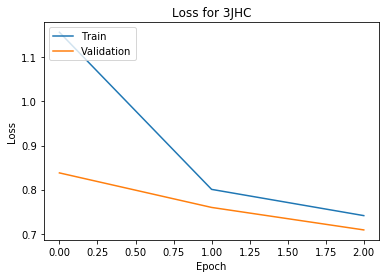

-0.34441012
Training 3JHN out of [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN]
Categories (8, object): [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN] 

Train on 149773 samples, validate on 16642 samples
Epoch 1/3
149773/149773 [==============================] - 2s 12us/step - loss: 0.7033 - val_loss: 0.5175
Epoch 2/3
149773/149773 [==============================] - 1s 10us/step - loss: 0.4571 - val_loss: 0.4474
Epoch 3/3
149773/149773 [==============================] - 1s 10us/step - loss: 0.4013 - val_loss: 0.4000


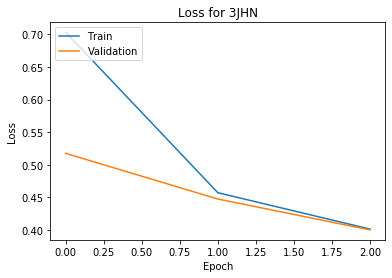

-0.9163086


In [26]:
from datetime import datetime

mol_types=train_csv["type"].unique()
cv_score=[]
cv_score_total=0
epoch_n = 3 #1000
verbose = 1
batch_size = 2048
    
# Set to True if we want to train from scratch.  False will reuse saved models as a starting point.
retrain =True

start_time=datetime.now()
test_prediction=np.zeros(len(test_csv))
input_features = ['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7',
       'atom_8','atom_9', 'atom_10','d_1_0', 'd_2_0', 'd_2_1', 'd_3_0',
       'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0',
       'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1', 'd_8_2',
       'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3', 'd_10_0', 'd_10_1', 'd_10_2',
       'd_10_3']



# Loop through each molecule type
for mol_type in mol_types:
    DATA_PATH = '../input/'

    model_name_wrt = ('../input_added/kaggle/molecule_model_%s.hdf5' % mol_type)
    print('Training %s' % mol_type, 'out of', mol_types, '\n')

    full = build_couple_dataframe(train_csv, structures_csv, mol_type, n_atoms=11)
    full2 = build_couple_dataframe(test_csv, structures_csv, mol_type, n_atoms=11)
    df_train_ = take_n_atoms(full, 11)
    df_test_ = take_n_atoms(full2, 11)
    df_train_  = df_train_.fillna(0)
    df_test_  = df_test_.fillna(0)
    
    # Standard Scaler from sklearn does seem to work better here than other Scalers
    input_data=StandardScaler().fit_transform(pd.concat([df_train_.loc[:,input_features],df_test_.loc[:,input_features]]))   
    #input_data=StandardScaler().fit_transform(df_train_.loc[:,input_features])
    target_data=df_train_.loc[:,"scalar_coupling_constant"].values

    # Simple split to provide us a validation set to do our CV checks with
    train_index, cv_index = train_test_split(np.arange(len(df_train_)),random_state=111, test_size=0.1)
    # Split all our input and targets by train and cv indexes
    train_target=target_data[train_index]
    cv_target=target_data[cv_index]
    train_input=input_data[train_index]
    cv_input=input_data[cv_index]
    test_input=input_data[len(df_train_):,:]

    # Build the Neural Net
    nn_model=create_nn_model(train_input.shape[1])
    
    # If retrain==False, then we load a previous saved model as a starting point.
    if not retrain:
        nn_model = load_model(model_name_rd)
        
    nn_model.compile(loss='mae', optimizer=Adam())#, metrics=[auc])
    
    # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
    es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=40,verbose=1, mode='auto', restore_best_weights=True)
    # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
    rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=30, min_lr=1e-6, mode='auto', verbose=1)
    # Save the best value of the model for future use
    sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True, period=1)
    history = nn_model.fit(train_input,[train_target], 
            validation_data=(cv_input,[cv_target]), 
            callbacks=[es, rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)
    
    cv_predict=nn_model.predict(cv_input)
    plot_history(history, mol_type)
    accuracy=np.mean(np.abs(cv_target-cv_predict[:,0]))
    print(np.log(accuracy))
    cv_score.append(np.log(accuracy))
    cv_score_total+=np.log(accuracy)
    
    # Predict on the test data set using our trained model
    test_predict=nn_model.predict(test_input)
    
    # for each molecule type we'll grab the predicted values
    test_prediction[test_csv["type"]==mol_type]=test_predict[:,0]
    K.clear_session()

cv_score_total/=len(mol_types)


In [27]:
print ('Total training time: ', datetime.now() - start_time)

i=0
for mol_type in mol_types: 
    print(mol_type,": cv score is ",cv_score[i])
    i+=1
print("total cv score is",cv_score_total)

Total training time:  0:07:07.751979
1JHC : cv score is  0.5713274
2JHH : cv score is  -0.65978986
1JHN : cv score is  3.7614846
2JHN : cv score is  -0.63539445
2JHC : cv score is  -0.3045957
3JHH : cv score is  -0.6600071
3JHC : cv score is  -0.34441012
3JHN : cv score is  -0.9163086
total cv score is 0.1015382707118988


In [30]:
def submits(predictions):
    submit["scalar_coupling_constant"] = predictions
    submit.to_csv("../input_added/kaggle/submission.csv", index=False)
submits(test_prediction)

Add more layers to get a better score! However,maybe,features are really more important than algorithms...